# Data preparation

In [8]:
import pandas as pd

# loading data
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [9]:
df_wrime

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Disgust,Reader3_Trust,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,1,2012/07/31 23:48,train,0,1,2,1,1,0,...,1,0,0,2,0,0,0,0,0,0
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,1,2012/08/02 23:09,train,3,0,3,0,0,0,...,0,1,1,0,0,2,0,0,0,0
2,早寝するつもりが飲み物がなくなりコンビニへ｡ん､今日、風が涼しいな。,1,2012/08/05 00:50,train,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,眠い、眠れない。,1,2012/08/08 01:36,train,0,2,1,0,0,1,...,2,0,0,1,0,0,0,0,1,0
4,ただいま? って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,1,2012/08/09 22:24,train,2,1,3,2,0,1,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43195,真夜中にふと思い立ち、ノートPCを持って部屋を出て、ダイニングで仕事したらすんごい捗った。\...,80,2020/09/15 08:01,train,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
43196,ぐっどこんでぃしょん。\n心も頭もクリア。\n秋分の日のおかげかな？\n人と自然としっとり過...,80,2020/09/22 01:52,train,1,0,1,0,0,0,...,0,0,2,0,2,0,0,0,0,0
43197,朝から免許の更新へ。\n90分で終わり、出口へ向かうと献血の呼びかけが。\nみんな通り過ぎて...,80,2020/09/23 22:32,train,2,0,2,1,0,0,...,0,0,2,0,0,0,0,0,0,0
43198,夜も更けて参りましたが、食後のコーヒーが飲みたいのでドリップ開始…\n\nぼんやり秋の夜長を...,80,2020/10/11 00:12,train,2,0,1,0,0,0,...,0,0,0,0,2,0,0,0,0,0


In [10]:
# the eight basic emotions by Plutchik. 
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
# Representations of them in Japanese. 
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼'] 

# 客観感情の平均（"Avg. Readers_*"） の値をlist化し、新しい列として定義する
# The added column has an element like [0, 2, 0, 0, 0, 0, 0, 0]. 
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)
df_wrime

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Trust,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust,readers_emotion_intensities
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,1,2012/07/31 23:48,train,0,1,2,1,1,0,...,0,0,2,0,0,0,0,0,0,"[0, 2, 0, 0, 0, 0, 0, 0]"
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,1,2012/08/02 23:09,train,3,0,3,0,0,0,...,1,1,0,0,2,0,0,0,0,"[1, 0, 0, 2, 0, 0, 0, 0]"
2,早寝するつもりが飲み物がなくなりコンビニへ｡ん､今日、風が涼しいな。,1,2012/08/05 00:50,train,1,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0]"
3,眠い、眠れない。,1,2012/08/08 01:36,train,0,2,1,0,0,1,...,0,0,1,0,0,0,0,1,0,"[0, 1, 0, 0, 0, 0, 1, 0]"
4,ただいま? って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,1,2012/08/09 22:24,train,2,1,3,2,0,1,...,0,1,0,0,1,0,0,0,0,"[1, 0, 0, 1, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43195,真夜中にふと思い立ち、ノートPCを持って部屋を出て、ダイニングで仕事したらすんごい捗った。\...,80,2020/09/15 08:01,train,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,"[1, 0, 0, 1, 0, 0, 0, 0]"
43196,ぐっどこんでぃしょん。\n心も頭もクリア。\n秋分の日のおかげかな？\n人と自然としっとり過...,80,2020/09/22 01:52,train,1,0,1,0,0,0,...,0,2,0,2,0,0,0,0,0,"[2, 0, 2, 0, 0, 0, 0, 0]"
43197,朝から免許の更新へ。\n90分で終わり、出口へ向かうと献血の呼びかけが。\nみんな通り過ぎて...,80,2020/09/23 22:32,train,2,0,2,1,0,0,...,0,2,0,0,0,0,0,0,0,"[2, 0, 0, 0, 0, 0, 0, 0]"
43198,夜も更けて参りましたが、食後のコーヒーが飲みたいのでドリップ開始…\n\nぼんやり秋の夜長を...,80,2020/10/11 00:12,train,2,0,1,0,0,0,...,0,0,0,2,0,0,0,0,0,"[0, 0, 2, 0, 0, 0, 0, 0]"


## Filtering out samples with low intensities of emotions. 

In [11]:
# 感情強度が低いサンプルは除外する (optional)
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [12]:
# 客観感情の平均（"Avg. Readers_*"）の列だけを抽出する
df_wrime_features = df_wrime_target.loc[:, 'Avg. Readers_Joy':'Avg. Readers_Trust']

# 次は解決したのでしたかね？ 2023-08-09. 
df_wrime_features.info() # なぜ平均なのにint型？

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18237 entries, 0 to 43199
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Avg. Readers_Joy           18237 non-null  int64
 1   Avg. Readers_Sadness       18237 non-null  int64
 2   Avg. Readers_Anticipation  18237 non-null  int64
 3   Avg. Readers_Surprise      18237 non-null  int64
 4   Avg. Readers_Anger         18237 non-null  int64
 5   Avg. Readers_Fear          18237 non-null  int64
 6   Avg. Readers_Disgust       18237 non-null  int64
 7   Avg. Readers_Trust         18237 non-null  int64
dtypes: int64(8)
memory usage: 1.3 MB


## Normalization

In [13]:
"""
from sklearn import preprocessing

# 正規化 (optional)
mm = preprocessing.MinMaxScaler()
df_wrime_features= pd.DataFrame(mm.fit_transform(df_wrime_features), columns=df_wrime_features.columns)
df_wrime_features.info()
"""

'\nfrom sklearn import preprocessing\n\n# 正規化 (optional)\nmm = preprocessing.MinMaxScaler()\ndf_wrime_features= pd.DataFrame(mm.fit_transform(df_wrime_features), columns=df_wrime_features.columns)\ndf_wrime_features.info()\n'

# Clustering

In [14]:
from sklearn.cluster import KMeans

# クラスタリング

# k: クラスター数 (optional)
k = 6

# k-means法の実行
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_wrime_features)
# 各サンプルのクラスター番号を取得する
clusters = kmeansModel.labels_
# clustersに1を足すことで、クラスター番号を1から始める
clusters = clusters + 1

/home/om/.miniconda3/envs/transformers/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


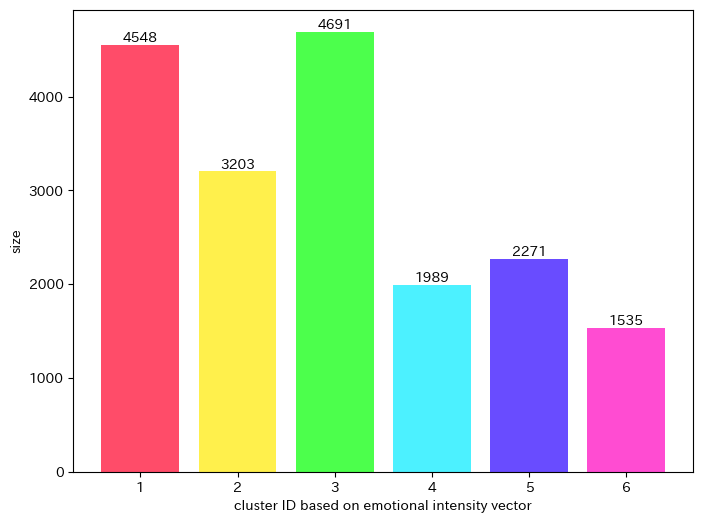

In [15]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
import numpy as np

# 日本語フォントの設定
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# 各クラスの度数を計算
unique_clusters, counts = np.unique(clusters, return_counts=True)

# カラーマップを取得
cmap_name = 'gist_rainbow'
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0, 1, len(unique_clusters)))

# Visualization. 
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_clusters, counts, color=colors, alpha=0.7)
plt.xlabel('Emotional intensity-based cluster ID')
# plt.ylabel('count')
plt.ylabel('size')
# plt.title(f'count for each 感情カテゴリ (k={k})')
plt.xticks(unique_clusters)

# テキストを表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

## クラスター数の決定

In [16]:
k_max=40

### エルボー法による最適クラスター数の調査
エルボー法では、SSE値(残差平方和)が急激に減少している部分において、SSE値が最も小さい点が最適なクラスター数であると判断する

/home/om/.miniconda3/envs/transformers/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/om/.miniconda3/envs/transformers/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/om/.miniconda3/envs/transformers/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/om/.miniconda3/envs/transformers/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

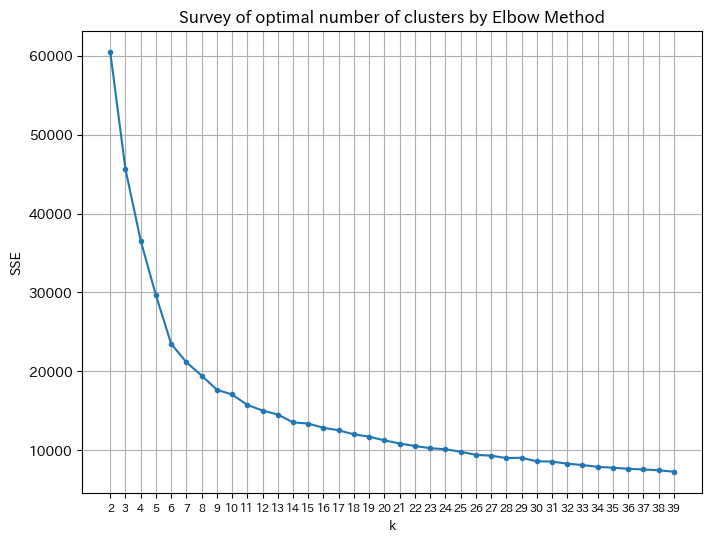

In [17]:

from sklearn.cluster import KMeans

# Survey of optimal number of clusters by Elbow Method
SSE = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)
    SSE.append(kmeans_model.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), SSE, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('SSE')
plt.title('Survey of optimal number of clusters by Elbow Method')
plt.grid(True)
plt.show()


### シルエット係数による最適クラスター数の調査

In [18]:

# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# # Survey of optimal number of clusters by Silhouette Coefficient
# silhouette_coefficients = []
# for i in range(2, k_max):
#     kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)
#     silhouette_coefficient = silhouette_score(df_wrime_features, kmeans_model.labels_) # シルエット係数の平均値
#     silhouette_coefficients.append(silhouette_coefficient)


# # 可視化
# plt.figure(figsize=(8, 6))
# plt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)
# plt.xlabel('k')
# plt.xticks(np.arange(2, k_max, 1), fontsize=8)
# plt.ylabel('Silhouette Coefficient')
# plt.title('Survey of optimal number of clusters by Silhouette Coefficient')
# plt.grid(True)
# plt.show()


/home/om/.miniconda3/envs/transformers/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/om/.miniconda3/envs/transformers/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/om/.miniconda3/envs/transformers/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/om/.miniconda3/envs/transformers/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

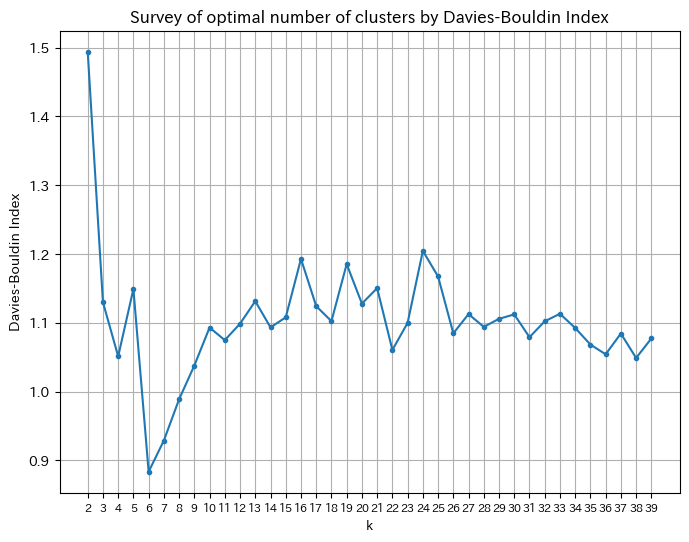

In [19]:
# Survey of optimal number of clusters by Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score

# クラスター数を変えて計算
dbi = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_wrime_features)
    dbi.append(davies_bouldin_score(df_wrime_features, kmeans_model.labels_))

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), dbi, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('Davies-Bouldin Index')
plt.title('Survey of optimal number of clusters by Davies-Bouldin Index')
plt.grid(True)
plt.show()

### シルエット図

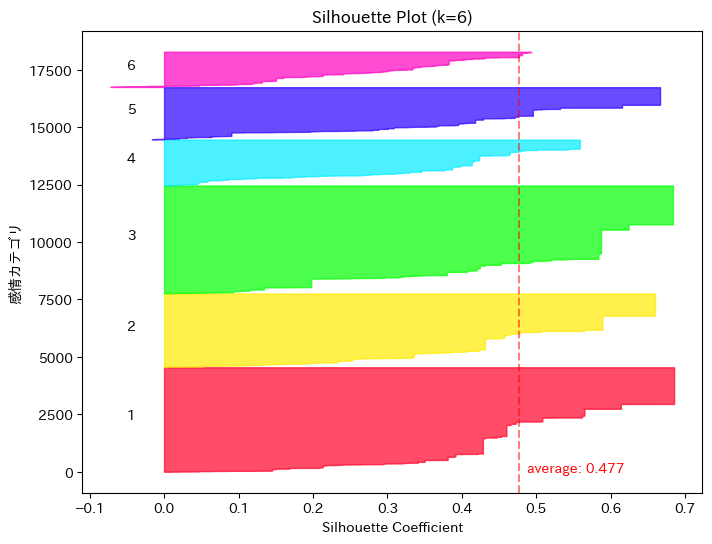

In [20]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_wrime_features, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_wrime_features, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i+1))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"average: {silhouette_avg:.3f}", color="red")

plt.xlabel('Silhouette Coefficient')
plt.ylabel('感情カテゴリ')
plt.title(f'Silhouette Plot (k={k})')
plt.show()

In [21]:
# 各感情カテゴリのシルエット係数が最も高い文章を表示
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'感情カテゴリ: {clusters[index]}')
    print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
    print('---')

感情カテゴリ: 1
シルエット係数が最も高い文章: やばい｡おもろいな?思ってみてみた「シャレードがいっぱい」｡よすぎるやん。
シルエット係数: 0.685
---
感情カテゴリ: 2
シルエット係数が最も高い文章: ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…
シルエット係数: 0.660
---
感情カテゴリ: 3
シルエット係数が最も高い文章: おなかすいた…夜ご飯仲間募集｡
シルエット係数: 0.684
---
感情カテゴリ: 4
シルエット係数が最も高い文章: 鬼滅クラスターあるな 
シルエット係数: 0.558
---
感情カテゴリ: 5
シルエット係数が最も高い文章: 西田辺は雷雨!!
シルエット係数: 0.666
---
感情カテゴリ: 6
シルエット係数が最も高い文章: これどうせジジババやんやろな(偏見) 
シルエット係数: 0.493
---


## クラスタリング結果の可視化

感情カテゴリ1：赤色

感情カテゴリ2：黄色

感情カテゴリ3：緑色

感情カテゴリ4：水色

感情カテゴリ5：青色

感情カテゴリ6：赤紫色

### PCA

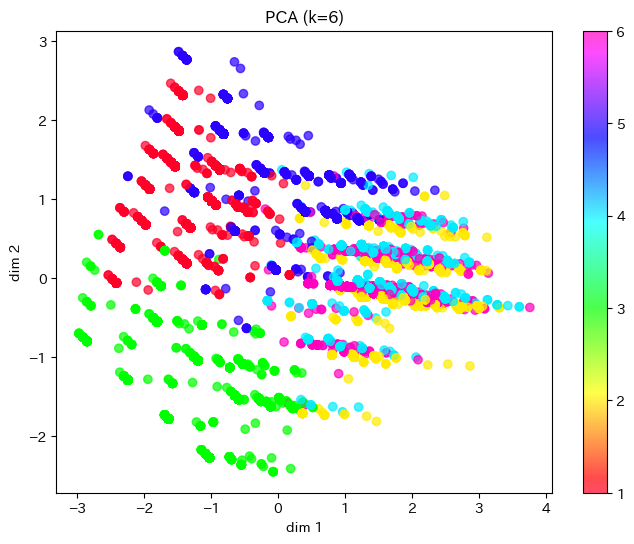

In [22]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca.fit(df_wrime_features)
df_wrime_features_pca = pca.transform(df_wrime_features)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_pca[:, 0], df_wrime_features_pca[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'PCA (k={k})')
plt.colorbar()
plt.show()

### t-SNE

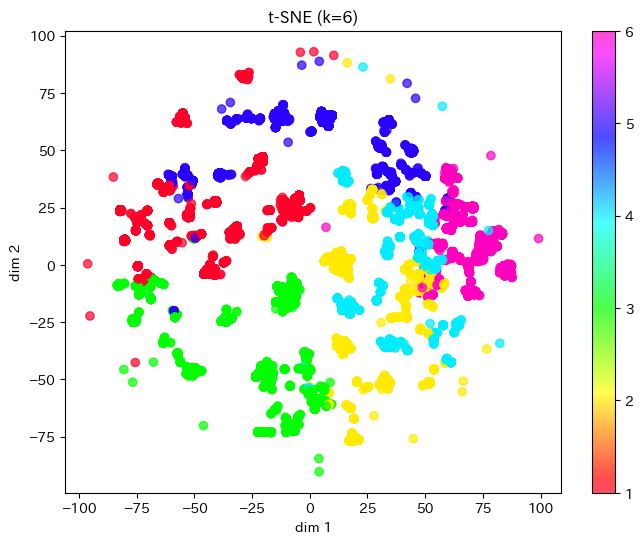

In [23]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
df_wrime_features_tsne = tsne.fit_transform(df_wrime_features)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={k})')
plt.colorbar()
plt.show()

### UMAP

/home/om/.miniconda3/envs/transformers/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/om/.miniconda3/envs/transformers/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/om/.miniconda3/envs/transformers/lib/python3.11/site-pac

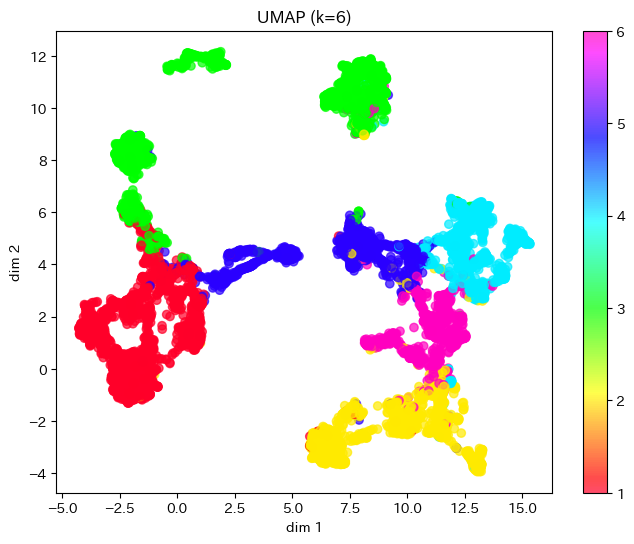

In [24]:
import umap

# UMAP
umap_obj = umap.UMAP(n_components=2, random_state=0, n_neighbors=10, metric='yule')
df_wrime_features_umap = umap_obj.fit_transform(df_wrime_features)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'UMAP (k={k})')
plt.colorbar()
plt.show()

# アノテーション

## 各感情カテゴリと説明変数(8つの基本感情)の関係

### 下の図は 青色(弱い) ↔ 黄色(強い)で、各感情カテゴリと説明変数(8つの基本感情)の関係を示す。

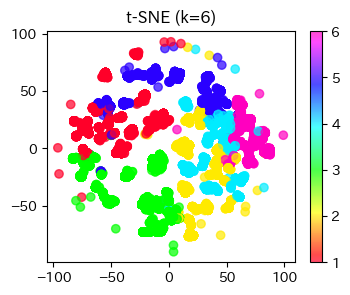

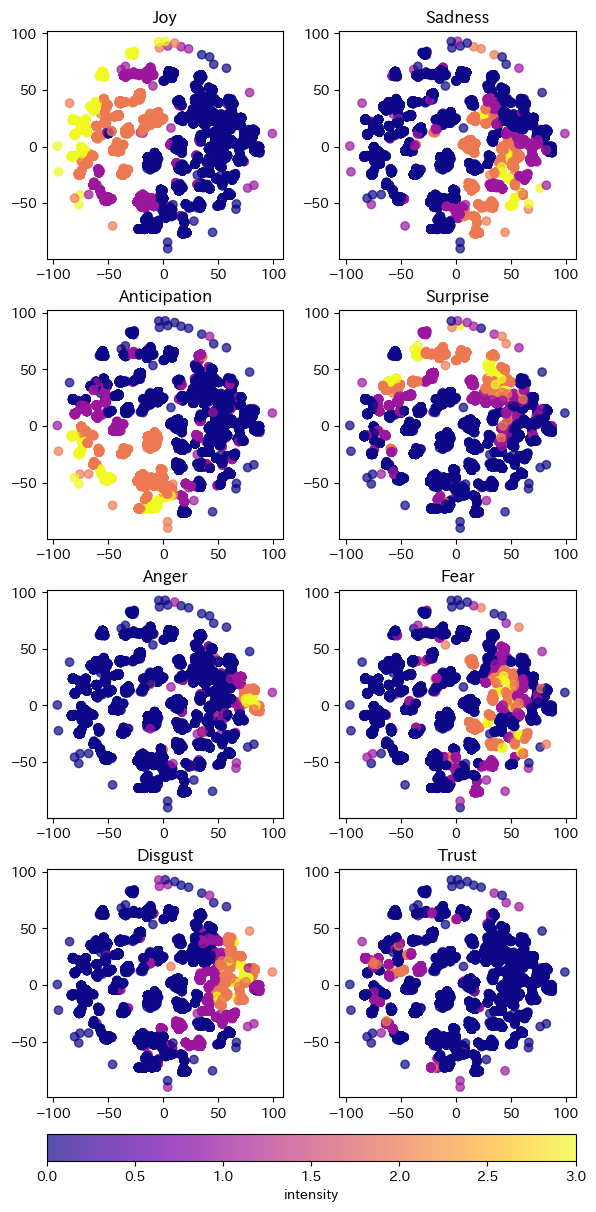

In [25]:
# UMAPによる可視化
plt.figure(figsize=(4, 3))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.title(f't-SNE (k={k})')
plt.colorbar()
plt.show()


# 説明変数の大小の可視化
fig = plt.figure(figsize=(6,13))
cols = df_wrime_features.columns
for i, col in enumerate(cols):
    ax = fig.add_subplot(4, 2, i+1, title=emotion_names[i])
    sc = ax.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1],
                    c=df_wrime_features[col], cmap='plasma', alpha=0.7)
fig.tight_layout()
fig.colorbar(sc, ax=fig.axes, orientation='horizontal', fraction=0.1, pad=0.03, label='intensity')

plt.show()

In [26]:
df_wrime_features_clusters = df_wrime_features.copy()
df_wrime_features_clusters['cluster'] = clusters
x = []
y = []
targets = []
colors = []
for i, col in enumerate(cols):
    for j in range(k+1):
        target_value = df_wrime_features_clusters[df_wrime_features_clusters['cluster']==j][col].mean()
        x.append(j)
        y.append(i)
        #targets.append(np.exp(1+target_value*3/2))
        targets.append(target_value*100)

In [27]:
df_wrime_features_clusters.groupby(clusters).mean()

,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust,cluster
1,2.200748,0.021328,0.304969,0.304310,0.001759,0.015391,0.005717,0.222735,1.0
2,0.016547,2.123322,0.064939,0.198564,0.031221,0.315954,0.533250,0.004683,2.0
3,0.673204,0.052014,2.190578,0.054146,0.004263,0.043061,0.024302,0.071200,3.0
4,0.022624,0.595777,0.077426,0.420814,0.012569,2.160382,0.482152,0.006033,4.0
5,0.513430,0.095112,0.103479,2.185821,0.010568,0.158520,0.094672,0.067812,5.0
6,0.014332,0.410423,0.044951,0.256678,1.027362,0.328339,2.121824,0.001303,6.0


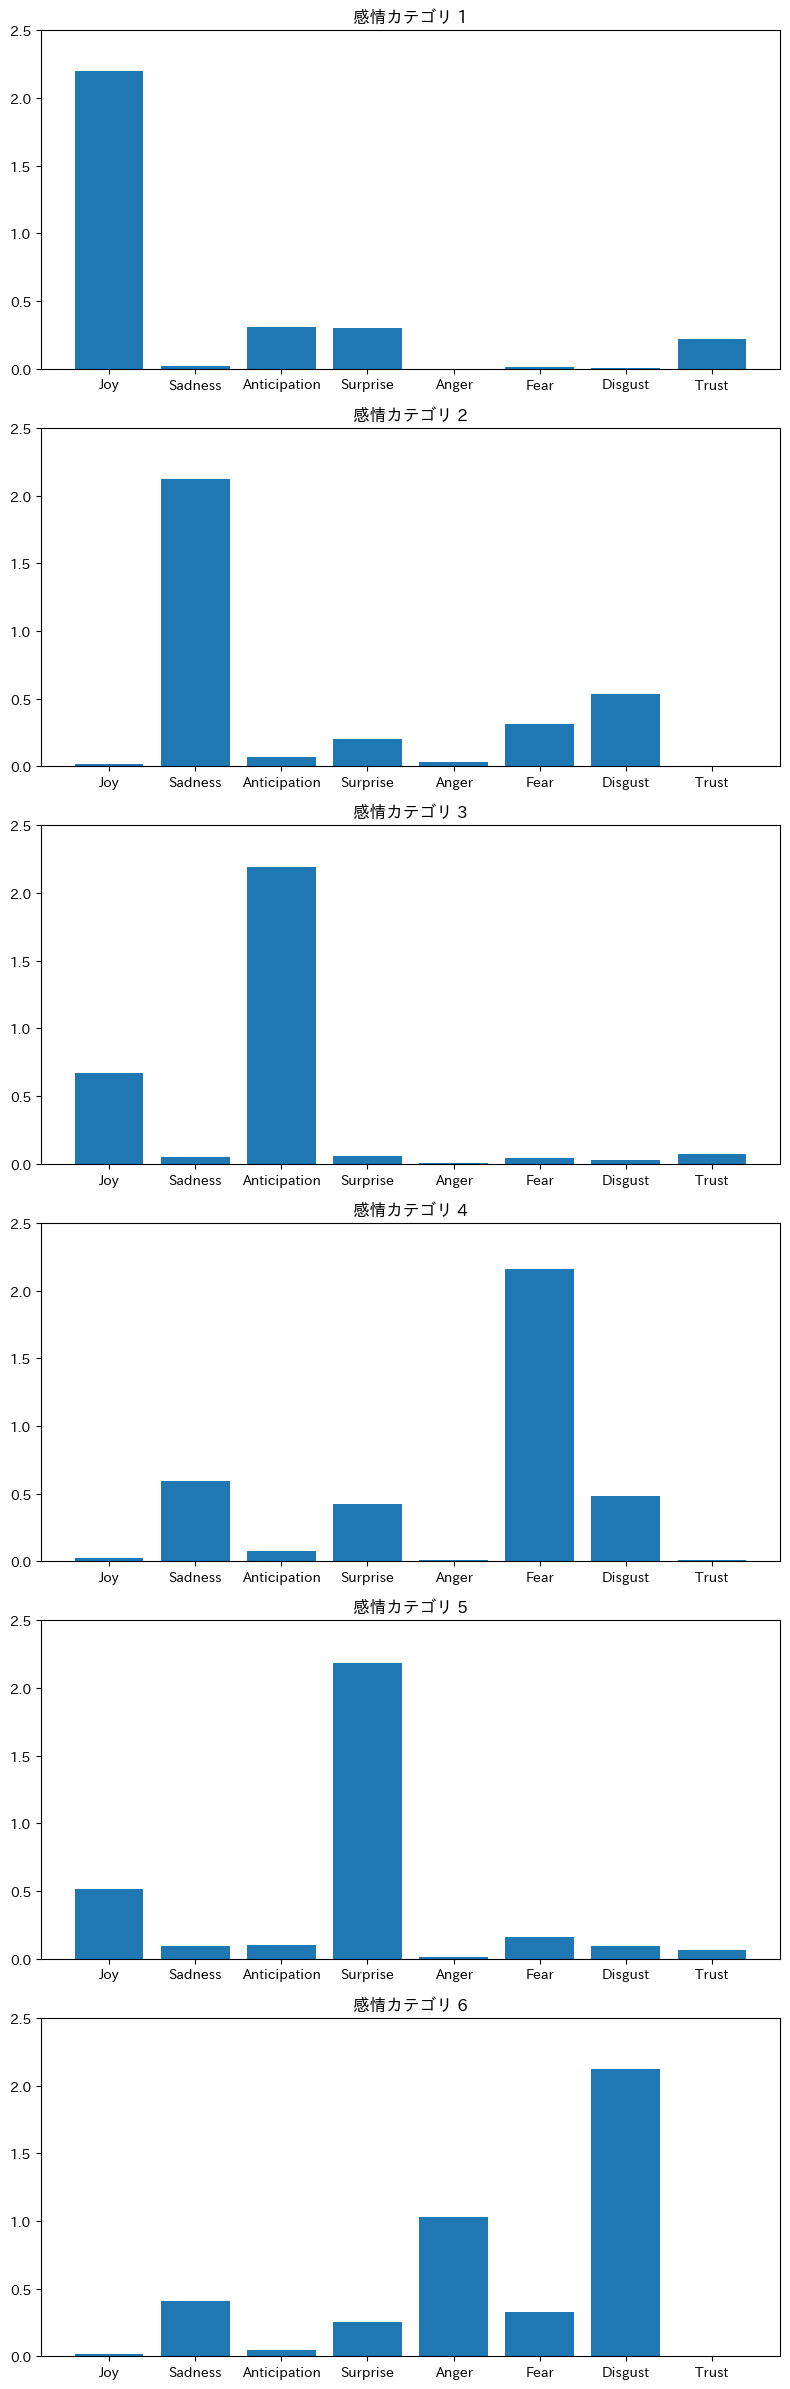

In [28]:
# データフレームを行ごとにサブプロットで表示するための設定
num_rows, num_cols = df_wrime_features_clusters.groupby(clusters).mean().shape
fig, axes = plt.subplots(num_rows, 1, figsize=(8, num_rows * 4))

# 行ごとにデータを取得し、各行に対して棒グラフを作成
for row_idx in range(num_rows):
    # row_data = df_wrime_features_clusters.groupby(clusters).mean().apply(np.log1p).iloc[row_idx, :]
    row_data = df_wrime_features_clusters.groupby(clusters).mean().iloc[row_idx, :]
    cluster_label = row_idx + 1

    # 各列の値を取得
    cluster_data = row_data.drop('cluster')
    column_names = cluster_data.index.tolist()
    column_values = cluster_data.values.tolist()

    # 棒グラフを作成
    axes[row_idx].bar(emotion_names, column_values)
    axes[row_idx].set_title(f'感情カテゴリ {cluster_label}')
    axes[row_idx].set_ylim(0, 2.5)

# レイアウトを調整して、グラフを表示
plt.tight_layout()
plt.show()

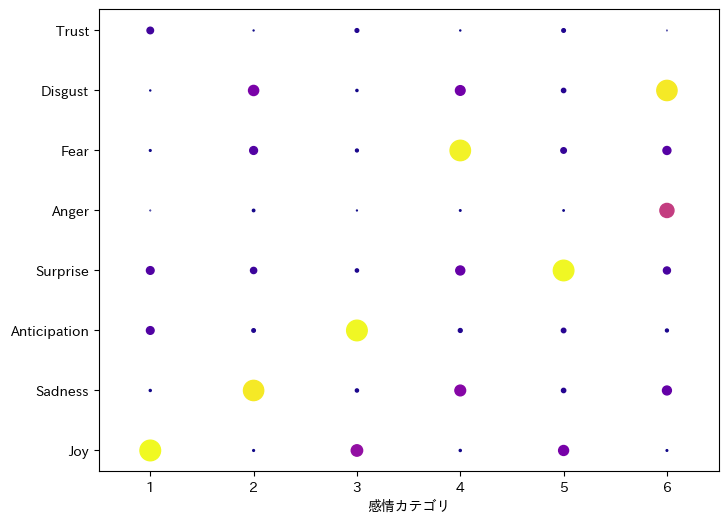

In [29]:

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x, y, s=targets, c=targets, cmap='plasma')
plt.xticks(list(range(k+1)), list(range(k+1)))
plt.yticks(list(range(len(cols))), emotion_names)
ax.set_xlim(+0.5, k+0.5)
plt.xlabel('感情カテゴリ')
plt.show()

In [30]:
# 各感情カテゴリのシルエット係数が最も高い文章を表示
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'感情カテゴリ: {clusters[index]}')
    print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
    print('---')

感情カテゴリ: 1
シルエット係数が最も高い文章: やばい｡おもろいな?思ってみてみた「シャレードがいっぱい」｡よすぎるやん。
シルエット係数: 0.685
---
感情カテゴリ: 2
シルエット係数が最も高い文章: ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…
シルエット係数: 0.660
---
感情カテゴリ: 3
シルエット係数が最も高い文章: おなかすいた…夜ご飯仲間募集｡
シルエット係数: 0.684
---
感情カテゴリ: 4
シルエット係数が最も高い文章: 鬼滅クラスターあるな 
シルエット係数: 0.558
---
感情カテゴリ: 5
シルエット係数が最も高い文章: 西田辺は雷雨!!
シルエット係数: 0.666
---
感情カテゴリ: 6
シルエット係数が最も高い文章: これどうせジジババやんやろな(偏見) 
シルエット係数: 0.493
---


In [31]:
# clustersを保存

# df_wrime_features_clusters['cluster'].to_csv('clusters/emotion_6clusters.tsv', sep='\t', header=False, index=None)
